In [1]:
library(raster)
library(ggmap)
library(spdep)
library(tmap)
library(rgdal)
library(classInt)
library(RColorBrewer)

Loading required package: sp
Loading required package: ggplot2
Loading required package: Matrix
Warning message:
“package ‘tmap’ was built under R version 3.4.3”rgdal: version: 1.2-16, (SVN revision 701)
 Geospatial Data Abstraction Library extensions to R successfully loaded
 Loaded GDAL runtime: GDAL 2.1.3, released 2017/20/01
 Path to GDAL shared files: /Library/Frameworks/GDAL.framework/Versions/2.1/Resources/gdal
 GDAL binary built with GEOS: TRUE 
 Loaded PROJ.4 runtime: Rel. 4.9.1, 04 March 2015, [PJ_VERSION: 491]
 Path to PROJ.4 shared files: /Library/Frameworks/R.framework/Versions/3.4/Resources/library/sf/proj
 Linking to sp version: 1.2-5 


In [2]:
s1 <- readOGR("data/akCity_CAU01_ethnic.shp")

OGR data source with driver: ESRI Shapefile 
Source: "data/akCity_CAU01_ethnic.shp", layer: "akCity_CAU01_ethnic"
with 101 features
It has 14 fields
Integer64 fields read as strings:  POLY_ID SUM_EUROPE SUM_MAORI SUM_PACIFI SUM_ASIAN SUM_OTHER SUM_TOTAL 


In [3]:
summary(s1)
#Let's see a summary of our spatial data

Object of class SpatialPolygonsDataFrame
Coordinates:
      min     max
x 2658430 2679068
y 6469654 6483715
Is projected: TRUE 
proj4string :
[+proj=nzmg +lat_0=-41 +lon_0=173 +x_0=2510000 +y_0=6023150
+datum=nzgd49 +units=m +no_defs +ellps=intl
+towgs84=59.47,-5.04,187.44,0.47,-0.1,1.024,-4.5993]
Data attributes:
    POLY_ID       CAU_ID                   FIRST_CAU_   SUM_EUROPE   SUM_MAORI 
 1      : 1   514000 : 1   Abbotts Park         : 1   1837   : 2   113    : 3  
 10     : 1   514101 : 1   Akarana              : 1   1096   : 1   160    : 3  
 100    : 1   514102 : 1   Arch Hill            : 1   1128   : 1   65     : 3  
 101    : 1   514103 : 1   Auckland Central East: 1   1129   : 1   306    : 2  
 11     : 1   514200 : 1   Auckland Central West: 1   1135   : 1   310    : 2  
 12     : 1   514301 : 1   Auckland Harbourside : 1   1157   : 1   74     : 2  
 (Other):95   (Other):95   (Other)              :95   (Other):94   (Other):86  
   SUM_PACIFI   SUM_ASIAN    SUM_OTHER    SU

In [4]:
names(s1)
#names -> gives you the header (first row) of your data

[1] "POLY_ID"    "CAU_ID"     "FIRST_CAU_" "SUM_EUROPE" "SUM_MAORI" 
 [6] "SUM_PACIFI" "SUM_ASIAN"  "SUM_OTHER"  "SUM_TOTAL"  "PC_EUROPEA"
[11] "PC_MAORI"   "PC_PACIFIC" "PC_ASIAN"   "PC_OTHER"

In [57]:
df <- data.frame(s1)
#The data frame -> row and header of data
df

,POLY_ID,CAU_ID,FIRST_CAU_,SUM_EUROPE,SUM_MAORI,SUM_PACIFI,SUM_ASIAN,SUM_OTHER,SUM_TOTAL,PC_EUROPEA,PC_MAORI,PC_PACIFIC,PC_ASIAN,PC_OTHER
0,1,514000,Freemans Bay,3002,339,262,182,289,4074,73.7,8.3,6.4,4.5,7.1
1,2,514101,Auckland Harbourside,995,49,42,310,173,1569,63.4,3.1,2.7,19.8,11.0
2,3,514102,Auckland Central West,1587,180,89,1062,489,3407,46.6,5.3,2.6,31.2,14.4
3,4,514103,Auckland Central East,1595,159,79,1309,526,3668,43.5,4.3,2.2,35.7,14.3
4,5,514200,Newton,529,65,28,131,118,871,60.7,7.5,3.2,15.0,13.5
5,6,514301,Grafton West,536,65,37,351,89,1078,49.7,6.0,3.4,32.6,8.3
6,7,514302,Grafton East,479,79,81,313,106,1058,45.3,7.5,7.7,29.6,10.0
7,8,514401,Roberton,2418,479,763,821,448,4929,49.1,9.7,15.5,16.7,9.1
8,9,514402,Glenavon,2039,536,1326,1311,407,5619,36.3,9.5,23.6,23.3,7.2
9,10,514500,New Windsor,2991,338,599,1835,382,6145,48.7,5.5,9.7,29.9,6.2


## Plotting the data on a map

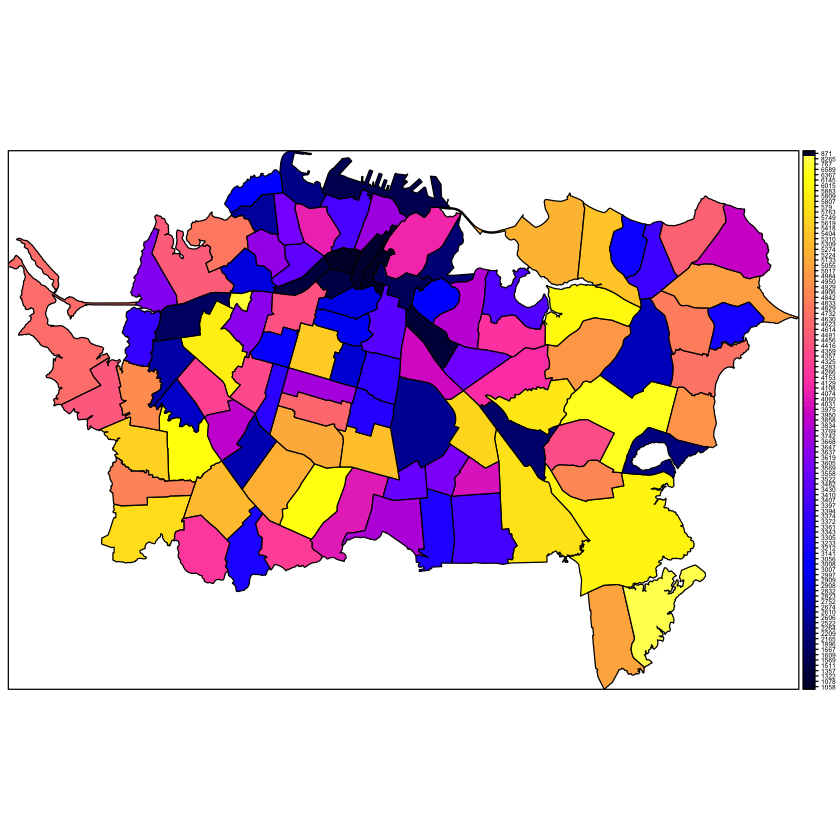

In [6]:
# Test plot the counties by `SUM_TOTAL` Column

spplot(s1, z="SUM_TOTAL", par.settings=list(fontsize=list(text=5)))

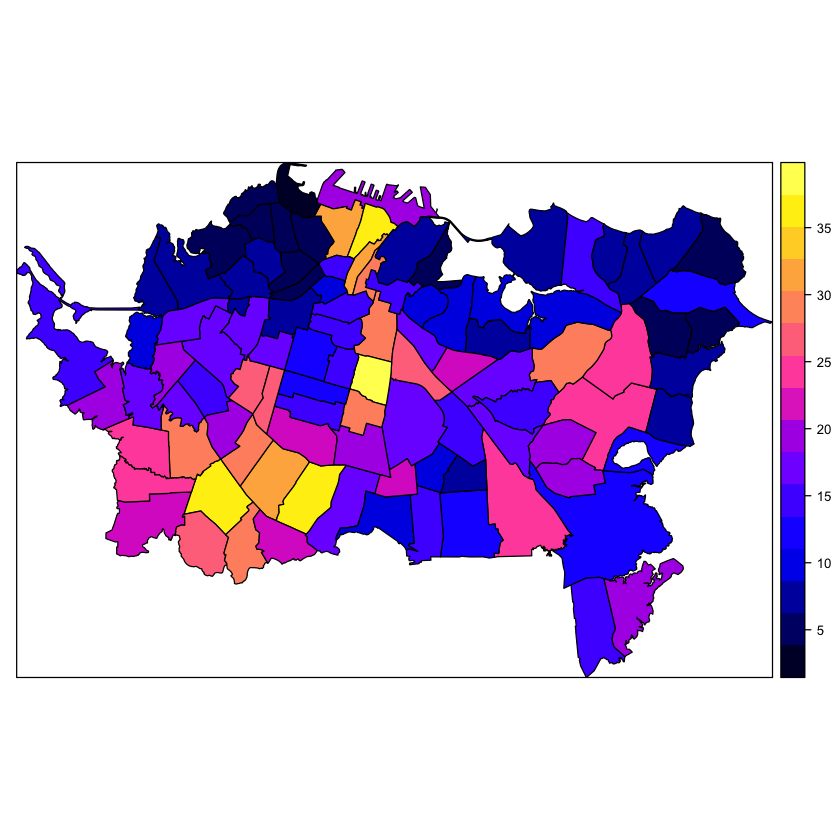

In [7]:
# Test plot the counties by `SUM_TOTAL` Column

spplot(s1, z="PC_ASIAN", par.settings=list(fontsize=list(text=10)))

## Equal Intervals Map

In [38]:
#First, let's make breaks in the data by using classIntervals()
#See https://www.rdocumentation.org/packages/classInt/versions/0.1-24/topics/classIntervals for
#Documentation of all options above
brks <-  classIntervals(s1$PC_ASIAN, n = 7, style = "equal")$brks
brks 
# 7 breaks, since we set n=7

brks[length(brks)] <- brks[length(brks)] + 1

[1]  3.800000  8.614286 13.428571 18.242857 23.057143 27.871429 32.685714
[8] 37.500000

In [39]:
# Custom colors using brewer
pal  <- brewer.pal(length(brks), "Blues")

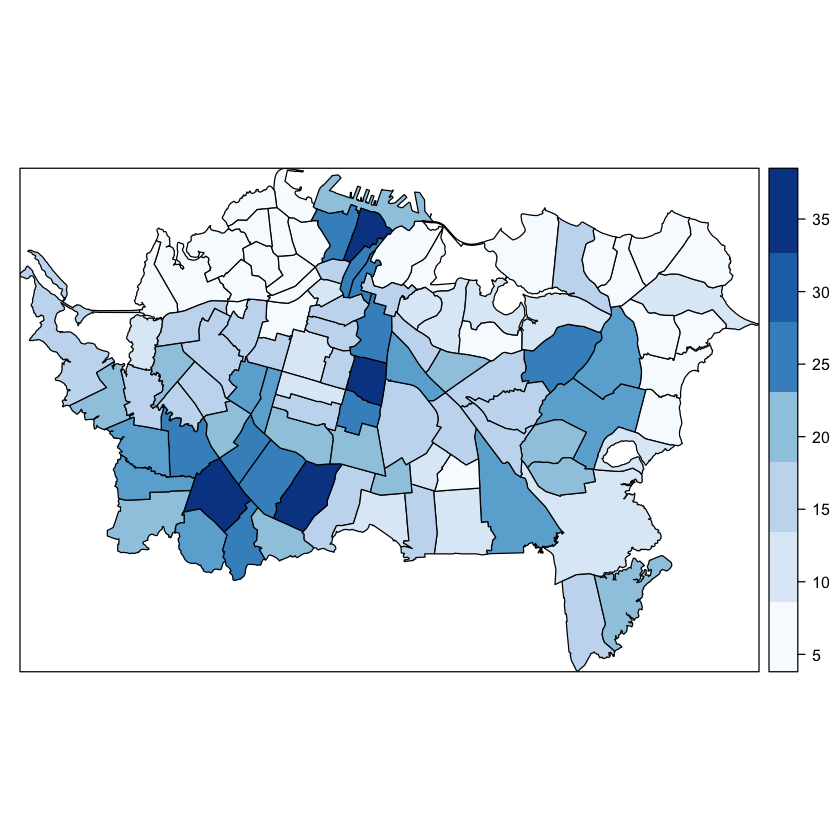

In [40]:

# Generate the map
spplot(s1, z="PC_ASIAN", at = brks, col.regions=pal)

## Standard Deviations Map

[1]  3.357102  7.693514 12.029925 16.366337 20.702748 25.039159 29.375571
[8] 33.711982 39.048394

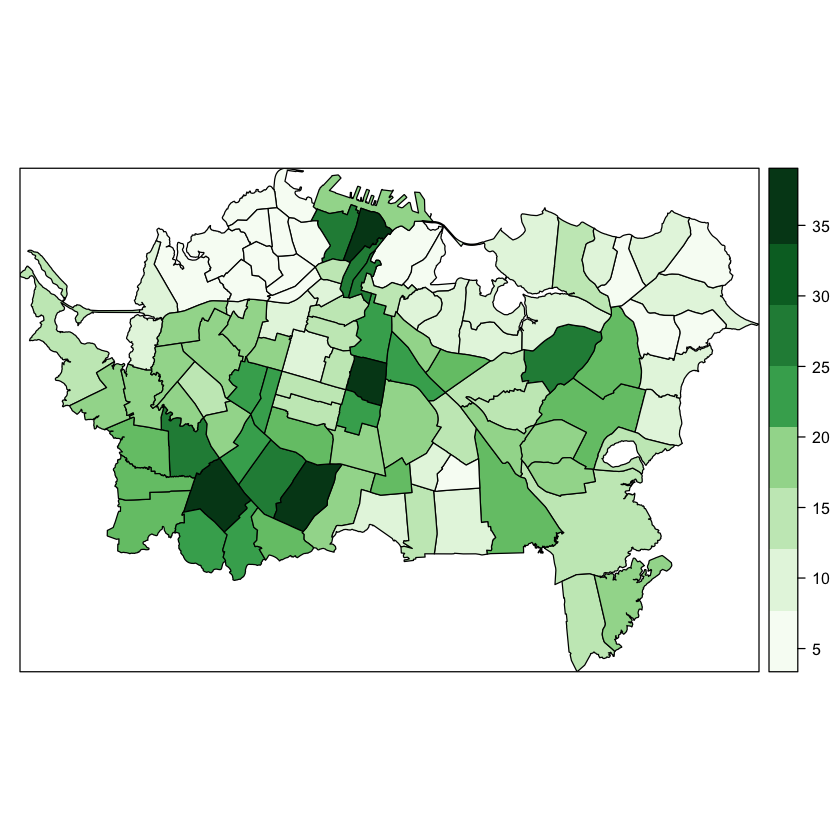

In [42]:
# Generate breaks
brks <-  classIntervals(s1$PC_ASIAN, style = "sd")$brks
brks[length(brks)] <- brks[length(brks)] + 1
brks
# Define color swatches
pal  <- brewer.pal(length(brks), "Greens")

# Generate the map
spplot(s1, z="PC_ASIAN", at = brks, col.regions=pal)

## Quantiles Map

[1]  3.80  6.55  8.40 12.20 15.40 18.00 22.10 28.15 38.50

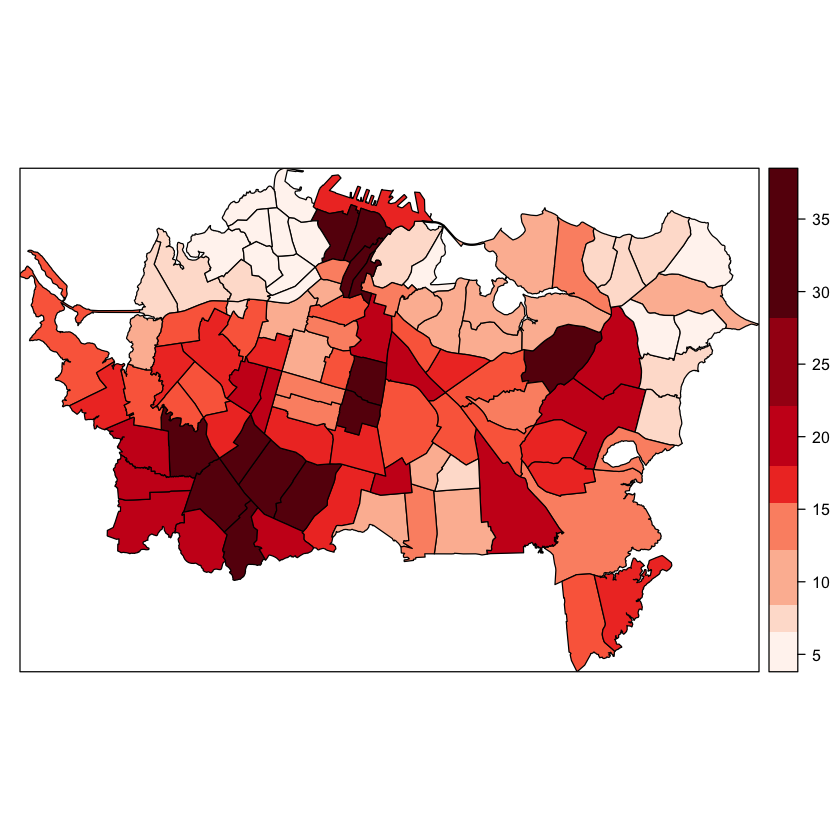

In [45]:
# Generate breaks
brks <-  classIntervals(s1$PC_ASIAN, style = "quantile")$brks
brks[length(brks)] <- brks[length(brks)] + 1
brks
# Define color swatches
pal  <- brewer.pal(length(brks), "Reds")

# Generate the map
spplot(s1, z="PC_ASIAN", at = brks, col.regions=pal)

## Natural Breaks (Jenks) map

In [80]:
# Generate breaks
brks <-  classIntervals(s1$PC_ASIAN, style = "fisher")$brks
brks[length(brks)] <- brks[length(brks)] + 1
brks
# Define color swatches
pal  <- brewer.pal(length(brks), "Purples")

# Generate the map
map <- spplot(s1, z="PC_ASIAN", at = brks, col.regions=pal)

s1$PC_ASIAN

[1]  3.80  6.55  9.45 12.80 16.90 21.20 26.05 31.55 38.50

[1]  4.5 19.8 31.2 35.7 15.0 32.6 29.6 16.7 23.3 29.9 25.0 22.1 15.4 19.6 10.0
 [16]  8.3  7.6 17.8  6.2  3.9  3.8  4.0  5.2  6.4  5.6  6.7  8.0  4.3 10.1 28.1
 [31] 37.5 28.5  5.5  7.4 17.1 21.9 16.2 10.3 10.0  9.7  8.4  9.2 29.6  8.4 13.7
 [46]  7.7  7.6  7.7  5.9 11.8  6.0  5.3  7.8 24.1 14.2  8.5 17.1 18.0 26.8 25.6
 [61] 18.1 18.9 17.6 15.4 15.4 14.5 11.8 15.5 13.2 14.7 21.9 19.9 35.7 18.0 20.2
 [76] 28.2 31.9 35.1 26.5 28.9 22.4 27.7 16.7 15.5 23.1 22.9 10.6 10.4 14.8  7.4
 [91] 12.0 13.9 16.4 24.6 20.0 19.7 13.3  7.9 12.4 20.5 15.5

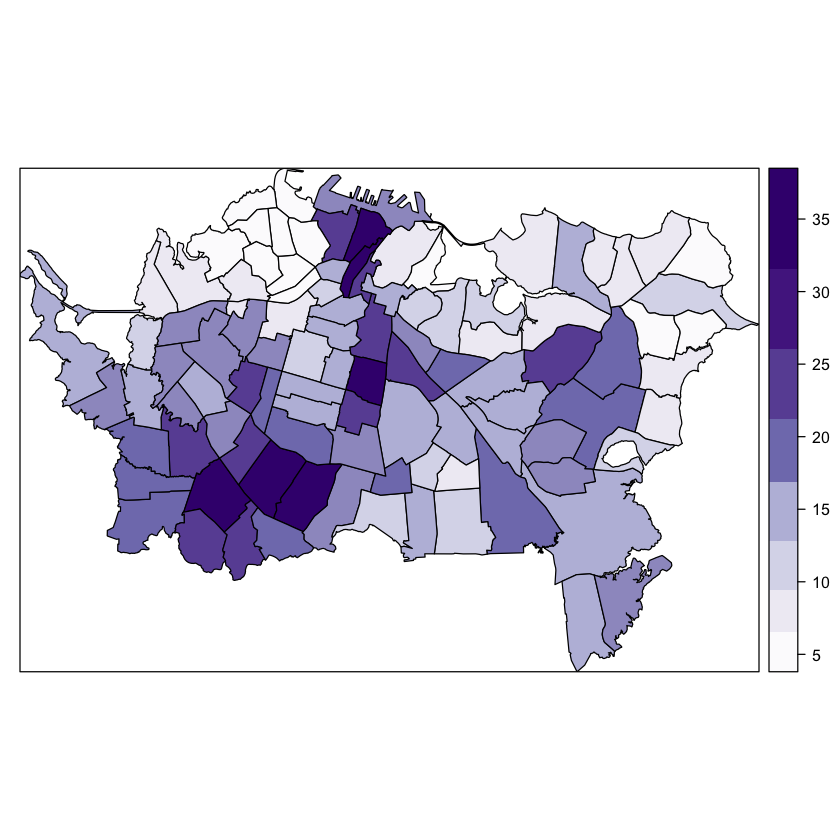

In [81]:
map

# Graphing the data

[1]  3.80  6.55  9.45 12.80 16.90 21.20 26.05 31.55 38.50

[1]  4.5 19.8 31.2 35.7 15.0 32.6 29.6 16.7 23.3 29.9 25.0 22.1 15.4 19.6 10.0
 [16]  8.3  7.6 17.8  6.2  3.9  3.8  4.0  5.2  6.4  5.6  6.7  8.0  4.3 10.1 28.1
 [31] 37.5 28.5  5.5  7.4 17.1 21.9 16.2 10.3 10.0  9.7  8.4  9.2 29.6  8.4 13.7
 [46]  7.7  7.6  7.7  5.9 11.8  6.0  5.3  7.8 24.1 14.2  8.5 17.1 18.0 26.8 25.6
 [61] 18.1 18.9 17.6 15.4 15.4 14.5 11.8 15.5 13.2 14.7 21.9 19.9 35.7 18.0 20.2
 [76] 28.2 31.9 35.1 26.5 28.9 22.4 27.7 16.7 15.5 23.1 22.9 10.6 10.4 14.8  7.4
 [91] 12.0 13.9 16.4 24.6 20.0 19.7 13.3  7.9 12.4 20.5 15.5

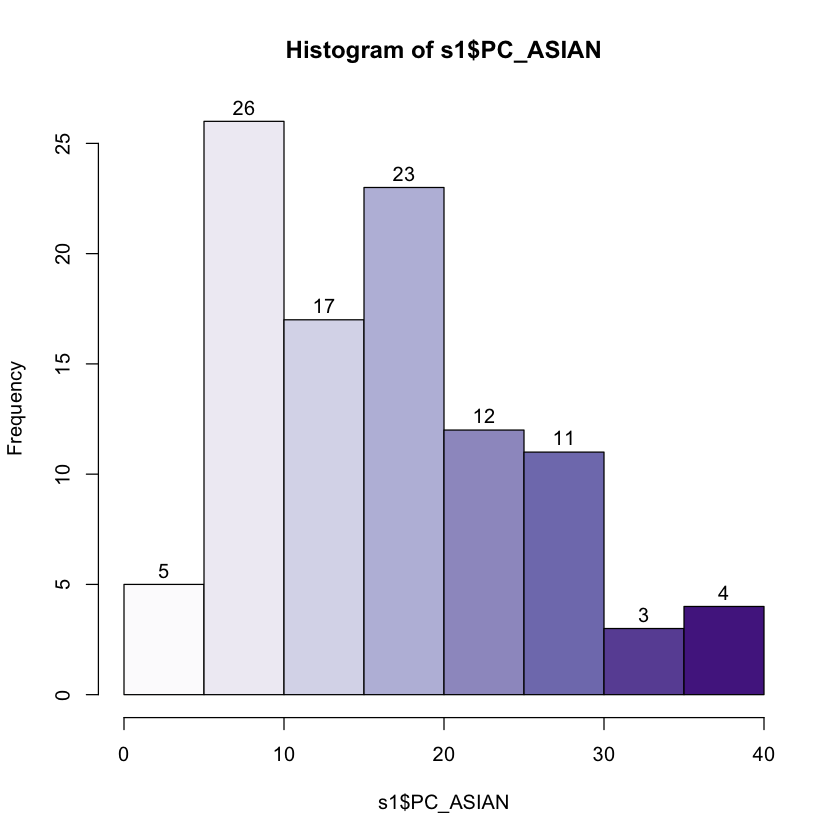

In [116]:
brks
s1$PC_ASIAN
hist(s1$PC_ASIAN, freq = TRUE, right=TRUE, labels=TRUE,col=pal)

# Spatial autocorrelation

In [300]:
# Generate the weight matrix
#queen = False, at least two boundary points must be within the snap distance of each other, with the conventional name of a ‘rook’ relationship.
#snap is the same as precision threshold in geoda

w <- poly2nb(s1, row.names=s1$FIRST_CAU_, queen=FALSE, snap=1e-05)

In [303]:
#example of the first polygon in w, numbers are the neighbors for the first polygon

w[1]
s1$FIRST_CAU_[1]


#make a summary of w
summary(w)

[[1]]
[1]  3  5 21 23 25

[1] Freemans Bay
101 Levels: Abbotts Park Akarana Arch Hill ... Westmere

Neighbour list object:
Number of regions: 101 
Number of nonzero links: 498 
Percentage nonzero weights: 4.881874 
Average number of links: 4.930693 
Link number distribution:

 2  3  4  5  6  7  8  9 
 5 12 20 30 22  7  4  1 
5 least connected regions:
Rosebank Kohimarama West Glendowie Otahuhu East Otahuhu West with 2 links
1 most connected region:
Mt Wellington North with 9 links


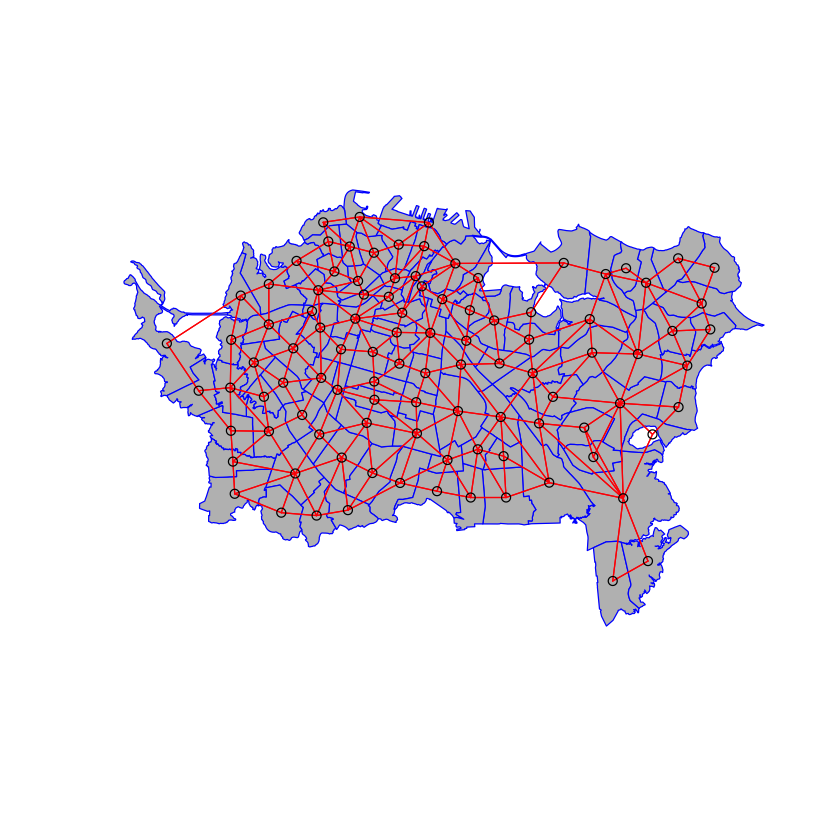

In [304]:
plot(s1, col='gray', border='blue', lwd=1)
xy <- coordinates(s1)
plot(w, xy, col='red', lwd=1, add=TRUE)

In [305]:
#style = B indicates show the weights as binaries (0 or 1)
wm <- nb2mat(w, style='B', zero.policy=TRUE)

In [309]:
#this is what the weight matrix looks like
wm

Freemans Bay,0,0,1,0,1,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
Auckland Harbourside,0,0,1,1,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
Auckland Central West,1,1,0,1,1,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
Auckland Central East,0,1,1,0,1,1,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
Newton,1,0,1,1,0,1,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
Grafton West,0,0,0,1,1,0,1,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
Grafton East,0,0,0,0,0,1,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
Roberton,0,0,0,0,0,0,0,0,1,1,⋯,0,0,0,0,0,0,0,0,0,0
Glenavon,0,0,0,0,0,0,0,1,0,1,⋯,0,0,0,0,0,0,0,0,0,0
New Windsor,0,0,0,0,0,0,0,1,1,0,⋯,0,0,0,0,0,0,0,0,0,0
Avondale South,0,0,0,0,0,0,0,0,1,1,⋯,0,0,0,0,0,0,0,0,0,0


## Moran's *I* in equation form

$I = \frac{n}{\sum_{i=1}^n (y_i - \bar{y})^2} \frac{\sum_{i=1}^n \sum_{j=1}^n w_{ij}(y_i - \bar{y})(y_j - \bar{y})}{\sum_{i=1}^n \sum_{j=1}^n w_{ij}}$

In [321]:
#manual computation

#n is the number of observations (length of our dataset)
n <- length(s1)

y <- s1$PC_ASIAN
ybar <- mean(y)

yi <- rep(dy, each=n)
yj <- rep(dy)
yiyj <- yi * yj

pm <- matrix(yiyj, ncol=n)

pmw <- pm * wm

spmw <- sum(pmw)

smw <- sum(wm)
sw  <- spmw / smw
vr <- n / sum(dy^2)
MI <- vr * sw
#Morans I
cat("Moran's I is", MI)

Moran's I is 0.4833353

[1] 0.4738716

In [280]:
lw <- nb2listw(w, style="W", zero.policy=TRUE)

In [322]:
summary(lw)

Characteristics of weights list object:
Neighbour list object:
Number of regions: 101 
Number of nonzero links: 534 
Percentage nonzero weights: 5.234781 
Average number of links: 5.287129 
Link number distribution:

 2  3  4  5  6  7  8  9 10 
 5 12 14 23 25 12  8  1  1 
5 least connected regions:
Rosebank Kohimarama West Glendowie Otahuhu East Otahuhu West with 2 links
1 most connected region:
Mt Wellington North with 10 links

Weights style: W 
Weights constants summary:
    n    nn  S0       S1      S2
W 101 10201 101 41.38853 414.514


In [323]:
PC_ASIAN.lag <- lag.listw(lw, s1$PC_ASIAN,zero.policy=TRUE)

In [324]:
M <- lm(PC_ASIAN.lag ~ s1$PC_ASIAN)

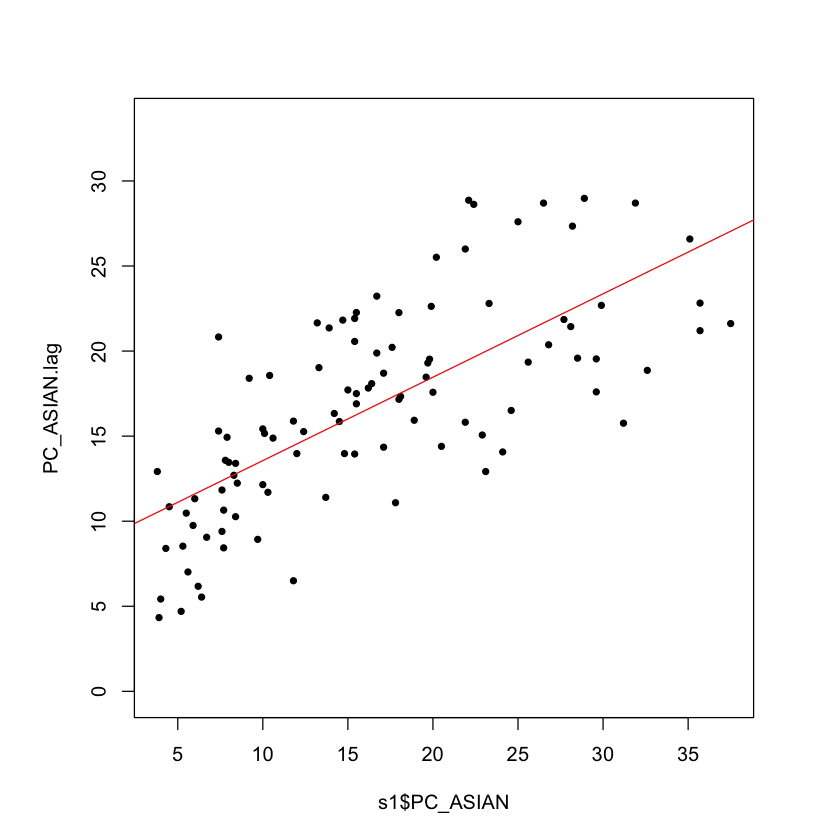

In [326]:
# Plot the data
OP <- par(pty="s")  # Force a square plot
 plot( PC_ASIAN.lag ~ s1$PC_ASIAN, pch=20, asp=1)
 abline(M, col="red") # Add the regression line from model M
par(OP) # Revert back to default plot settings

In [381]:
moran(s1$PC_ASIAN,lw, n=length(lw$neighbours), S0=Szero(lw))

$I
[1] 0.4904778

$K
[1] 2.385732

In [382]:
moran.test(s1$PC_ASIAN, lw, randomisation=FALSE)


	Moran I test under normality

data:  s1$PC_ASIAN  
weights: lw  

Moran I statistic standard deviate = 8.0665, p-value = 3.617e-16
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
      0.490477789      -0.010000000       0.003849454 


In [383]:
moran.mc(s1$PC_ASIAN, lw, nsim=99)


	Monte-Carlo simulation of Moran I

data:  s1$PC_ASIAN 
weights: lw  
number of simulations + 1: 100 

statistic = 0.49048, observed rank = 100, p-value = 0.01
alternative hypothesis: greater


In [384]:
#moran's scatterplot

n <- length(s1)
ms <- cbind(id=rep(1:n, each=n), y=rep(y, each=n), value=as.vector(wm * y))


PC_ASIAN,PC_ASIAN lagged
4.5,12.16000
19.8,19.52500
31.2,15.76000
35.7,21.20000
15.0,19.73333
32.6,18.86667


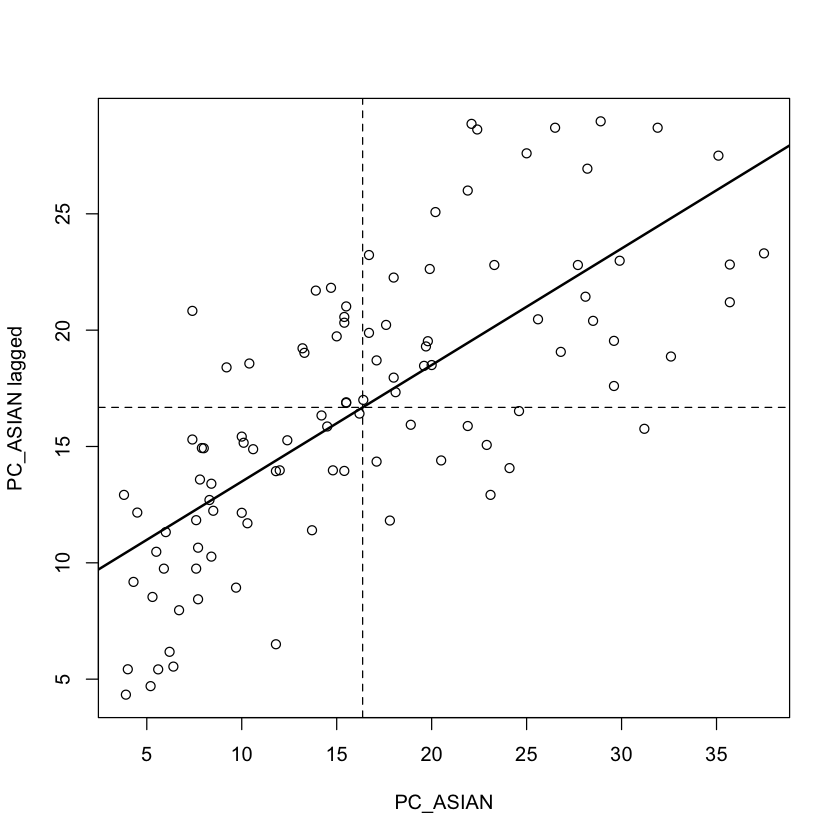

In [388]:
ms <- ms[ms[,3] > 0, ]

ams <- aggregate(ms[,2:3], list(ms[,1]), FUN=mean)
ams <- ams[,-1]
colnames(ams) <- c('PC_ASIAN', 'PC_ASIAN lagged')
head(ams)

plot(ams)
reg <- lm(ams[,2] ~ ams[,1])
abline(reg, lwd=2)
abline(h=mean(ams[,2]), lt=2)
abline(v=ybar, lt=2)


In [386]:
#Univariate Local Moran’s I

In [391]:
#locm <- localmoran(s1$PC_ASIAN, lw)

is.vector(s1$PC_ASIAN)

#summary(locm)

[1] FALSE

In [376]:
s1$PC_ASIAN <- scale(s1$PC_ASIAN) 

s1$lag_PC_ASIAN <- lag.listw(lw, s1$PC_ASIAN,zero.policy=TRUE)

In [377]:
summary(s1$lag_PC_ASIAN)
head(s1$PC_ASIAN)

       V1          
 Min.   :-1.38744  
 1st Qu.:-0.42274  
 Median : 0.01656  
 Mean   : 0.03695  
 3rd Qu.: 0.51451  
 Max.   : 1.45381  

-1.3682208
0.3959107
1.7103616
2.2292238
-0.1575423
1.8717854


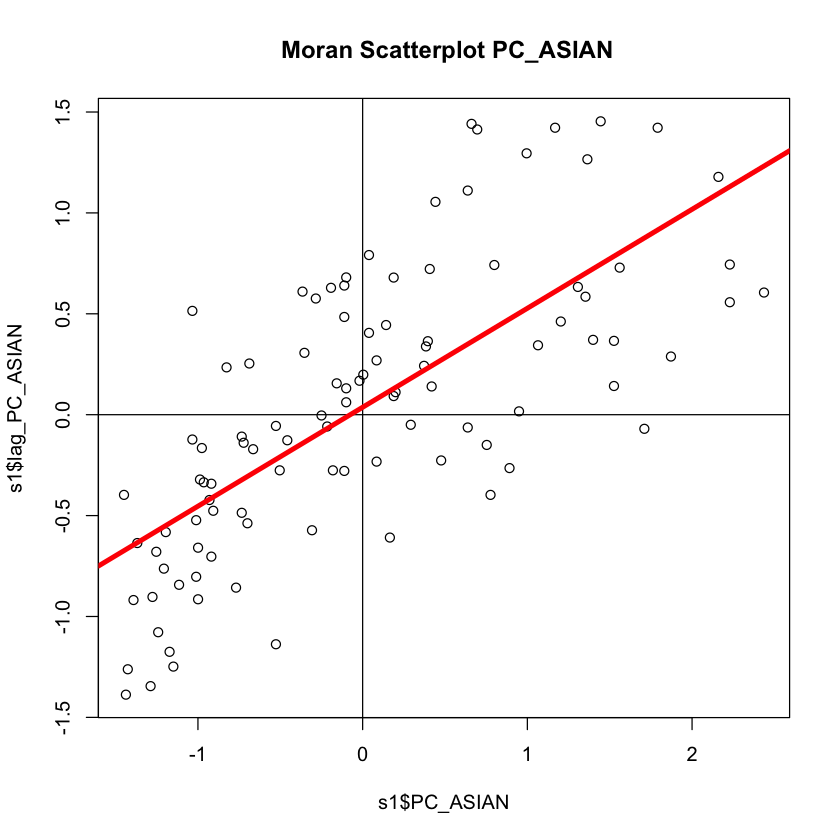

In [367]:
plot(x = s1$PC_ASIAN, y = s1$lag_PC_ASIAN, main = " Moran Scatterplot PC_ASIAN")
abline(h = 0, v = 0)
abline(lm(s1$lag_PC_ASIAN ~ s1$PC_ASIAN), lty = 1, lwd = 4, col = "red")
